In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, DateType
from pyspark.sql.functions import col, sum as _sum, avg, when
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create Spark Session
spark = SparkSession.builder.getOrCreate()


In [3]:
# Define schema
schema = StructType([
    StructField("order_id", StringType()),
    StructField("region", StringType()),
    StructField("category", StringType()),
    StructField("quantity", IntegerType()),
    StructField("price", DoubleType()),
    StructField("order_date", DateType())
])

# Inline data
data = [
    ("O001", "South", "Electronics", 3, 15000.0, date(2025, 1, 5)),
    ("O002", "North", "Clothing", 5, 2000.0, date(2025, 1, 6)),
    ("O003", "East", "Furniture", 2, 12000.0, date(2025, 1, 7)),
    ("O004", "West", "Electronics", 1, 18000.0, date(2025, 1, 8)),
    ("O005", "North", "Furniture", 4, 9000.0, date(2025, 1, 10)),
    ("O006", "South", "Clothing", 6, 2500.0, date(2025, 1, 11)),
    ("O007", "East", "Electronics", 2, 17000.0, date(2025, 1, 12)),
    ("O008", "South", "Furniture", 5, 8500.0, date(2025, 1, 15)),
    ("O009", "West", "Clothing", 7, 3000.0, date(2025, 1, 17)),
    ("O010", "North", "Electronics", 4, 16000.0, date(2025, 1, 18))
]


# Create DataFrame
df = spark.createDataFrame(data, schema)
df.show(10, truncate=False)


+--------+------+-----------+--------+-------+----------+
|order_id|region|category   |quantity|price  |order_date|
+--------+------+-----------+--------+-------+----------+
|O001    |South |Electronics|3       |15000.0|2025-01-05|
|O002    |North |Clothing   |5       |2000.0 |2025-01-06|
|O003    |East  |Furniture  |2       |12000.0|2025-01-07|
|O004    |West  |Electronics|1       |18000.0|2025-01-08|
|O005    |North |Furniture  |4       |9000.0 |2025-01-10|
|O006    |South |Clothing   |6       |2500.0 |2025-01-11|
|O007    |East  |Electronics|2       |17000.0|2025-01-12|
|O008    |South |Furniture  |5       |8500.0 |2025-01-15|
|O009    |West  |Clothing   |7       |3000.0 |2025-01-17|
|O010    |North |Electronics|4       |16000.0|2025-01-18|
+--------+------+-----------+--------+-------+----------+



In [4]:
df = df.withColumn("revenue", col("quantity") * col("price"))
df.show()


+--------+------+-----------+--------+-------+----------+-------+
|order_id|region|   category|quantity|  price|order_date|revenue|
+--------+------+-----------+--------+-------+----------+-------+
|    O001| South|Electronics|       3|15000.0|2025-01-05|45000.0|
|    O002| North|   Clothing|       5| 2000.0|2025-01-06|10000.0|
|    O003|  East|  Furniture|       2|12000.0|2025-01-07|24000.0|
|    O004|  West|Electronics|       1|18000.0|2025-01-08|18000.0|
|    O005| North|  Furniture|       4| 9000.0|2025-01-10|36000.0|
|    O006| South|   Clothing|       6| 2500.0|2025-01-11|15000.0|
|    O007|  East|Electronics|       2|17000.0|2025-01-12|34000.0|
|    O008| South|  Furniture|       5| 8500.0|2025-01-15|42500.0|
|    O009|  West|   Clothing|       7| 3000.0|2025-01-17|21000.0|
|    O010| North|Electronics|       4|16000.0|2025-01-18|64000.0|
+--------+------+-----------+--------+-------+----------+-------+



/tmp/ipython-input-1682570586.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="category", y="total_revenue", data=category_rev, palette="viridis")


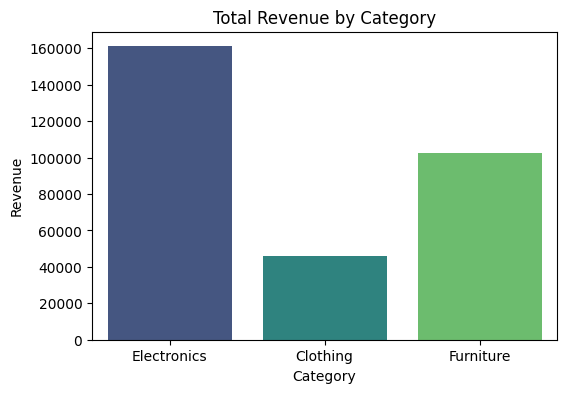

In [5]:
category_rev = df.groupBy("category").agg(_sum("revenue").alias("total_revenue")).toPandas()

plt.figure(figsize=(6,4))
sns.barplot(x="category", y="total_revenue", data=category_rev, palette="viridis")
plt.title("Total Revenue by Category")
plt.ylabel("Revenue")
plt.xlabel("Category")
plt.show()



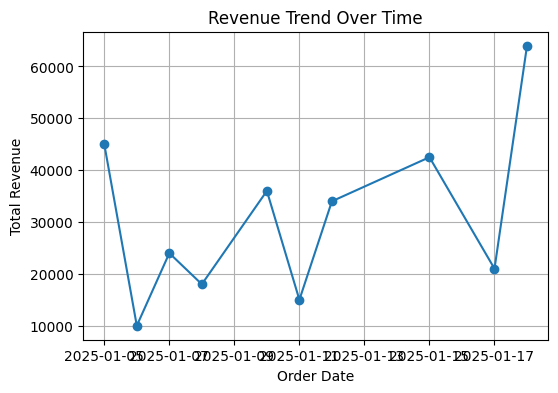

In [6]:
rev_trend = df.groupBy("order_date").agg(_sum("revenue").alias("total_revenue")).orderBy("order_date").toPandas()

plt.figure(figsize=(6,4))
plt.plot(rev_trend["order_date"], rev_trend["total_revenue"], marker="o")
plt.title("Revenue Trend Over Time")
plt.xlabel("Order Date")
plt.ylabel("Total Revenue")
plt.grid(True)
plt.show()


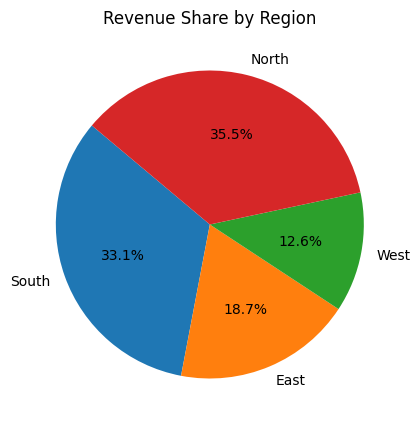

In [7]:
region_rev = df.groupBy("region").agg(_sum("revenue").alias("total_revenue")).toPandas()

plt.figure(figsize=(5,5))
plt.pie(region_rev["total_revenue"], labels=region_rev["region"], autopct="%1.1f%%", startangle=140)
plt.title("Revenue Share by Region")
plt.show()


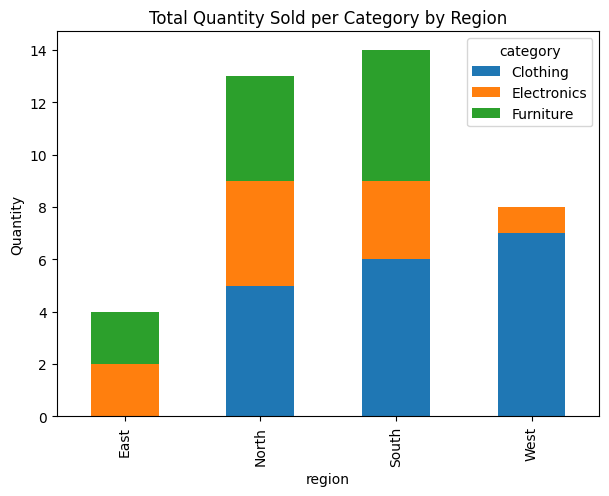

In [8]:
cat_region_qty = df.groupBy("region", "category").agg(_sum("quantity").alias("total_quantity")).toPandas()
pivot_qty = cat_region_qty.pivot(index="region", columns="category", values="total_quantity").fillna(0)

pivot_qty.plot(kind="bar", stacked=True, figsize=(7,5))
plt.title("Total Quantity Sold per Category by Region")
plt.ylabel("Quantity")
plt.show()


/tmp/ipython-input-946727382.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="total_revenue", y="order_id", data=top5, palette="magma")


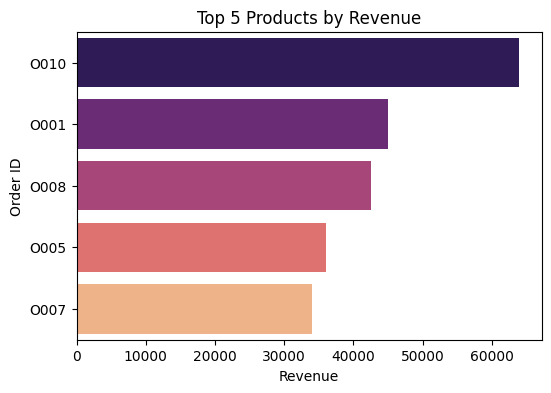

In [9]:
top5 = df.groupBy("order_id").agg(_sum("revenue").alias("total_revenue")).orderBy(col("total_revenue").desc()).limit(5).toPandas()

plt.figure(figsize=(6,4))
sns.barplot(x="total_revenue", y="order_id", data=top5, palette="magma")
plt.title("Top 5 Products by Revenue")
plt.xlabel("Revenue")
plt.ylabel("Order ID")
plt.show()


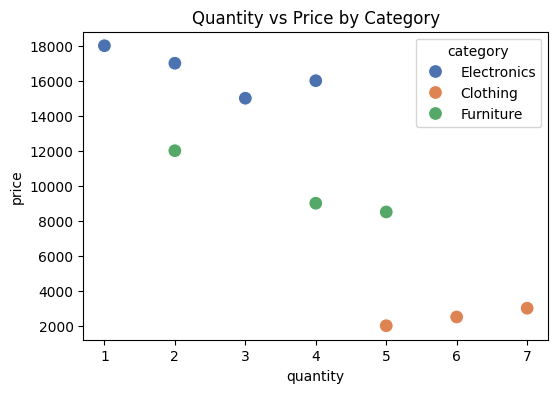

In [10]:
pdf = df.toPandas()

plt.figure(figsize=(6,4))
sns.scatterplot(x="quantity", y="price", hue="category", data=pdf, s=100, palette="deep")
plt.title("Quantity vs Price by Category")
plt.show()


/tmp/ipython-input-605152119.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="region", y="avg_order_value", data=avg_order_val, palette="coolwarm")


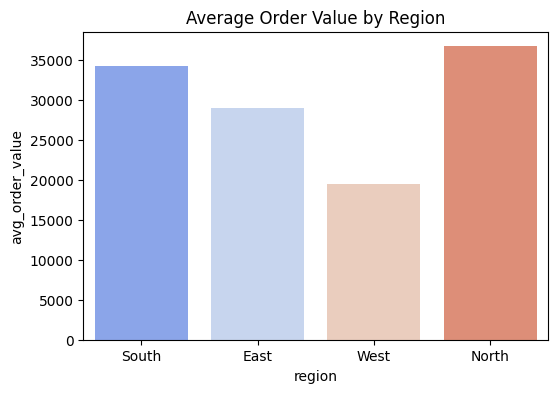

In [11]:
avg_order_val = df.groupBy("region").agg(avg("revenue").alias("avg_order_value")).toPandas()

plt.figure(figsize=(6,4))
sns.barplot(x="region", y="avg_order_value", data=avg_order_val, palette="coolwarm")
plt.title("Average Order Value by Region")
plt.show()


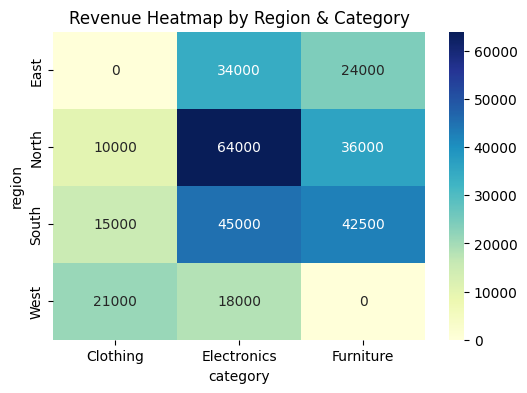

In [12]:
heatmap_data = df.groupBy("region", "category").agg(_sum("revenue").alias("total_revenue")).toPandas()
pivot_heatmap = heatmap_data.pivot(index="region", columns="category", values="total_revenue").fillna(0)

plt.figure(figsize=(6,4))
sns.heatmap(pivot_heatmap, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Revenue Heatmap by Region & Category")
plt.show()


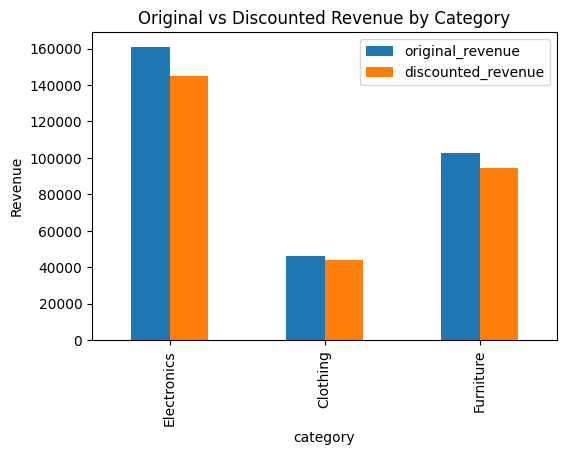

In [13]:
df_discount = df.withColumn("discount",
    when(col("category")=="Electronics", col("revenue")*0.10)
    .when(col("category")=="Clothing", col("revenue")*0.05)
    .when(col("category")=="Furniture", col("revenue")*0.08)
    .otherwise(0)
)

df_discount = df_discount.withColumn("discounted_revenue", col("revenue") - col("discount"))

cat_rev = df_discount.groupBy("category").agg(
    _sum("revenue").alias("original_revenue"),
    _sum("discounted_revenue").alias("discounted_revenue")
).toPandas()

cat_rev.plot(x="category", kind="bar", figsize=(6,4))
plt.title("Original vs Discounted Revenue by Category")
plt.ylabel("Revenue")
plt.show()


/tmp/ipython-input-834091771.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="category", y="total_revenue", data=category_rev, palette="viridis")


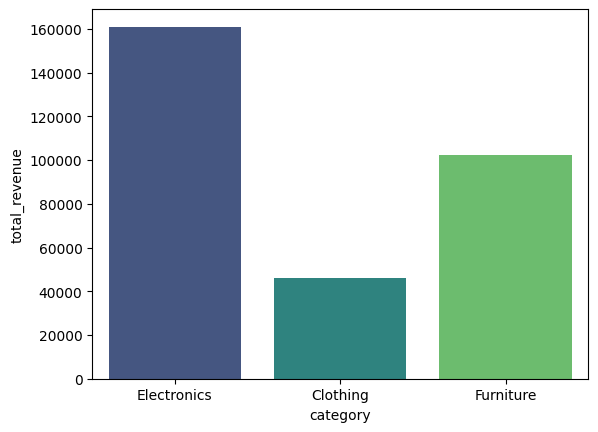

In [14]:
import os
os.makedirs("/content/sales_viz", exist_ok=True)

# Example for one plot:
plt.figure()
sns.barplot(x="category", y="total_revenue", data=category_rev, palette="viridis")
plt.savefig("/content/sales_viz/revenue_by_category.png")
